In [ ]:
!pip install textblob
!pip install pydot
!pip install pydotplus
!pip install graphviz
!pip install nltk
!pip install scikit-learn

In [39]:
## libraries
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

import numpy as np
import pandas as pd
import nltk
import sklearn

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('sentiwordnet')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
import string
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split


## lexicons
from textblob import TextBlob
from nltk.corpus import sentiwordnet as swn

## visualisation
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, trim, first ,when,to_timestamp,udf, from_unixtime,regexp_replace,date_format,substring,StringType

from pyspark.sql.types import ArrayType, IntegerType,DoubleType
import io
import matplotlib.pyplot as plt

# Suppress warning messages
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hduser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [11]:
spark = SparkSession.builder.master("local").config("spark.driver.memory", "15g").appName("CsvReader").getOrCreate()


In [12]:
## read csv 
twitter_data = spark.read.format("csv").load("file:///home/hduser/Desktop/CA2_TweetAnalysis/ProjectTweets.csv")

In [13]:
twitter_data.show(10)

+---+----------+--------------------+--------+---------------+--------------------+
|_c0|       _c1|                 _c2|     _c3|            _c4|                 _c5|
+---+----------+--------------------+--------+---------------+--------------------+
|  0|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|  1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|  2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|  3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|  4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|  5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|  6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|  7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|  8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nop

In [14]:
print(twitter_data.columns)

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5']


In [15]:
# Rename columns
twitter_data = twitter_data.selectExpr("_c1 as id", "_c2 as date", "_c3 as flag", "_c4 as user", "_c5 as text")

In [16]:
twitter_data.show(10)

+----------+--------------------+--------+---------------+--------------------+
|        id|                date|    flag|           user|                text|
+----------+--------------------+--------+---------------+--------------------+
|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|
|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|1467812025|Mon Apr 06 22:20:...|NO_QUER

In [17]:
twitter_data.count()

1600000

In [18]:
#check tweet and date format
first_row = twitter_data.first()
print(first_row['text'])

print(first_row['date'])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Mon Apr 06 22:19:45 PDT 2009


In [19]:
# Use regexp_replace to remove PDT from the date_string
twitter_data = twitter_data.withColumn("date", regexp_replace(twitter_data["date"], " PDT", ""))

first_row=twitter_data.first()
print(first_row['text'])

print(first_row['date'])

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Mon Apr 06 22:19:45 2009


In [20]:
#formated date columns as yyyy mm dd hh:mm:ss format
df=twitter_data
df = df.withColumn("new_date", substring(col("date"), 5,25))
# Use the to_timestamp function to convert the date_string to a timestamp
df = df.withColumn("timestamp", to_timestamp(df["new_date"], "MMM dd HH:mm:ss yyyy"))

# Use the date_format function to format the timestamp as desired
df = df.withColumn("formatted_date", date_format(df["timestamp"], "yyyy MM dd HH:mm:ss"))

# Show the DataFrame
df.show()

+----------+--------------------+--------+---------------+--------------------+--------------------+-------------------+-------------------+
|        id|                date|    flag|           user|                text|            new_date|          timestamp|     formatted_date|
+----------+--------------------+--------+---------------+--------------------+--------------------+-------------------+-------------------+
|1467810369|Mon Apr 06 22:19:...|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|Apr 06 22:19:45 2009|2009-04-06 22:19:45|2009 04 06 22:19:45|
|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|Apr 06 22:19:49 2009|2009-04-06 22:19:49|2009 04 06 22:19:49|
|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|Apr 06 22:19:53 2009|2009-04-06 22:19:53|2009 04 06 22:19:53|
|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|Apr 06 22:19:57 2009|2009-04-06 22:19:57|2009 04 06 22:19:57|
|1467811193|M

In [21]:
df.columns

['id',
 'date',
 'flag',
 'user',
 'text',
 'new_date',
 'timestamp',
 'formatted_date']

In [22]:
df=df[['id',
 'flag',
 'user',
 'text',
 'formatted_date']]
df.show()

+----------+--------+---------------+--------------------+-------------------+
|        id|    flag|           user|                text|     formatted_date|
+----------+--------+---------------+--------------------+-------------------+
|1467810369|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009 04 06 22:19:45|
|1467810672|NO_QUERY|  scotthamilton|is upset that he ...|2009 04 06 22:19:49|
|1467810917|NO_QUERY|       mattycus|@Kenichan I dived...|2009 04 06 22:19:53|
|1467811184|NO_QUERY|        ElleCTF|my whole body fee...|2009 04 06 22:19:57|
|1467811193|NO_QUERY|         Karoli|@nationwideclass ...|2009 04 06 22:19:57|
|1467811372|NO_QUERY|       joy_wolf|@Kwesidei not the...|2009 04 06 22:20:00|
|1467811592|NO_QUERY|        mybirch|         Need a hug |2009 04 06 22:20:03|
|1467811594|NO_QUERY|           coZZ|@LOLTrish hey  lo...|2009 04 06 22:20:03|
|1467811795|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|2009 04 06 22:20:05|
|1467812025|NO_QUERY|        mimismo|@twittera que m

## Mongo DB

In [14]:
#!pip install pymongo

In [ ]:
##mongodb connection
import pymongo
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["twitter_data"]
collection = db["tweets"]

In [ ]:
# clean collection 
#collection.drop()

In [ ]:
#insert data to mongodb 
rows = df.collect()
data_list = [row.asDict() for row in rows]

#insert
for data in data_list:
    collection.insert_one(data)


In [ ]:
#read data from mongodb
# Retrieve the data from the MongoDB collection
mongo_data = list(collection.find().limit(5))
mongo_data

In [ ]:
record_count = collection.count_documents({})
record_count


## Spark SQL

In [23]:
## spark sql
df.createOrReplaceTempView("twitter_data")
result = spark.sql("SELECT * FROM twitter_data")
result.show()

+----------+--------+---------------+--------------------+-------------------+
|        id|    flag|           user|                text|     formatted_date|
+----------+--------+---------------+--------------------+-------------------+
|1467810369|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009 04 06 22:19:45|
|1467810672|NO_QUERY|  scotthamilton|is upset that he ...|2009 04 06 22:19:49|
|1467810917|NO_QUERY|       mattycus|@Kenichan I dived...|2009 04 06 22:19:53|
|1467811184|NO_QUERY|        ElleCTF|my whole body fee...|2009 04 06 22:19:57|
|1467811193|NO_QUERY|         Karoli|@nationwideclass ...|2009 04 06 22:19:57|
|1467811372|NO_QUERY|       joy_wolf|@Kwesidei not the...|2009 04 06 22:20:00|
|1467811592|NO_QUERY|        mybirch|         Need a hug |2009 04 06 22:20:03|
|1467811594|NO_QUERY|           coZZ|@LOLTrish hey  lo...|2009 04 06 22:20:03|
|1467811795|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|2009 04 06 22:20:05|
|1467812025|NO_QUERY|        mimismo|@twittera que m

In [24]:
result.count()


1600000

## Sentiment Analysis

In [25]:
# cleaning text 
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()




In [26]:
X=df.select("text")
X.show(10)

+--------------------+
|                text|
+--------------------+
|@switchfoot http:...|
|is upset that he ...|
|@Kenichan I dived...|
|my whole body fee...|
|@nationwideclass ...|
|@Kwesidei not the...|
|         Need a hug |
|@LOLTrish hey  lo...|
|@Tatiana_K nope t...|
|@twittera que me ...|
+--------------------+
only showing top 10 rows



### Textblob

In [27]:
# Download NLTK stopwords data
nltk.download('stopwords')
nltk.download('punkt')

# Define a function to tokenize, remove stopwords, and clean punctuation
def preprocess_text(text):
    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words("english"))
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Remove punctuation and convert to lowercase
    clean_words = [word.lower() for word in filtered_words if word.isalpha()]

    # Join the cleaned words into a single string
    return " ".join(clean_words)

# Create a user-defined function (UDF) for text preprocessing
preprocess_udf = udf(preprocess_text, StringType())

# Apply the UDF to the DataFrame
processed_df = result.withColumn("text_processed", preprocess_udf(col("text")))

# Perform TextBlob sentiment analysis on the preprocessed text
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Create a UDF for sentiment analysis
sentiment_udf = udf(analyze_sentiment, StringType())

# Apply the UDF to the preprocessed DataFrame
sentiment_df = processed_df.withColumn("sentiment_score", sentiment_udf(col("text_processed")))

# Show the DataFrame with sentiment scores
sentiment_df.show(truncate=False)

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/hduser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+----------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------+--------------------+
|id        |flag    |user           |text                                                                                                                 |formatted_date     |text_processed                                                          |sentiment_score     |
+----------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------+--------------------+
|1467810369|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  |2009 04 06 22:19:45|switchfoot http

In [28]:
sentiment_df.select("text_processed","sentiment_score").show(2,truncate=False)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+------------------------------------------------------------------------+---------------+
|text_processed                                                          |sentiment_score|
+------------------------------------------------------------------------+---------------+
|switchfoot http awww bummer shoulda got david carr third day            |0.2            |
|upset ca update facebook texting might cry result school today also blah|0.0            |
+------------------------------------------------------------------------+---------------+
only showing top 2 rows



In [29]:
sentiment_df.select("text","text_processed").show(2,truncate=False)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------+
|text                                                                                                               |text_processed                                                          |
+-------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------+
|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D|switchfoot http awww bummer shoulda got david carr third day            |
|is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    |upset ca update facebook texting might cry result school today also blah|
+--------------------------------------------

### Vader

In [30]:
!pip install vaderSentiment

Defaulting to user installation because normal site-packages is not writeable


In [31]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.types import FloatType

analyzer = SentimentIntensityAnalyzer()

# Define a function to apply Vader sentiment analysis
def analyze_sentiment(text):
    sentiment_score = analyzer.polarity_scores(text)["compound"]
    return sentiment_score

# Create a user-defined function (UDF) for sentiment analysis
sentiment_udf = udf(analyze_sentiment, FloatType())

# Apply the UDF to the DataFrame
sentiment_df = sentiment_df.withColumn("sentiment_vader_score", sentiment_udf("text_processed"))

# Show the DataFrame with sentiment scores
sentiment_df.show(truncate=False)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+----------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------+--------------------+---------------------+
|id        |flag    |user           |text                                                                                                                 |formatted_date     |text_processed                                                          |sentiment_score     |sentiment_vader_score|
+----------+--------+---------------+---------------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------+--------------------+---------------------+
|1467810369|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Ca

In [32]:
sentiment_df.select("text_processed","sentiment_vader_score").show(2,truncate=False)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+------------------------------------------------------------------------+---------------------+
|text_processed                                                          |sentiment_vader_score|
+------------------------------------------------------------------------+---------------------+
|switchfoot http awww bummer shoulda got david carr third day            |-0.3818              |
|upset ca update facebook texting might cry result school today also blah|-0.7269              |
+------------------------------------------------------------------------+---------------------+
only showing top 2 rows



In [33]:
def get_sentiment_label(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"
    

get_sentiment_label_udf = udf(lambda score: get_sentiment_label(score), StringType())
    
sentiment_df = sentiment_df.withColumn("sentiment", get_sentiment_label_udf(sentiment_df["sentiment_vader_score"]))

# Show the DataFrame with sentiment labels
sentiment_df.show(5,truncate=False)


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+----------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------+---------------+---------------------+---------+
|id        |flag    |user           |text                                                                                                               |formatted_date     |text_processed                                                          |sentiment_score|sentiment_vader_score|sentiment|
+----------+--------+---------------+-------------------------------------------------------------------------------------------------------------------+-------------------+------------------------------------------------------------------------+---------------+---------------------+---------+
|1467810369|NO_QUERY|_TheSpecialOne_|@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got

In [34]:
sentiment_df.columns

['id',
 'flag',
 'user',
 'text',
 'formatted_date',
 'text_processed',
 'sentiment_score',
 'sentiment_vader_score',
 'sentiment']

In [35]:
final_df=sentiment_df[['id',
 'flag',
 'user',
 'text',
 'formatted_date',
 'sentiment']]

final_df.show(2)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+----------+--------+---------------+--------------------+-------------------+---------+
|        id|    flag|           user|                text|     formatted_date|sentiment|
+----------+--------+---------------+--------------------+-------------------+---------+
|1467810369|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009 04 06 22:19:45| negative|
|1467810672|NO_QUERY|  scotthamilton|is upset that he ...|2009 04 06 22:19:49| negative|
+----------+--------+---------------+--------------------+-------------------+---------+
only showing top 2 rows



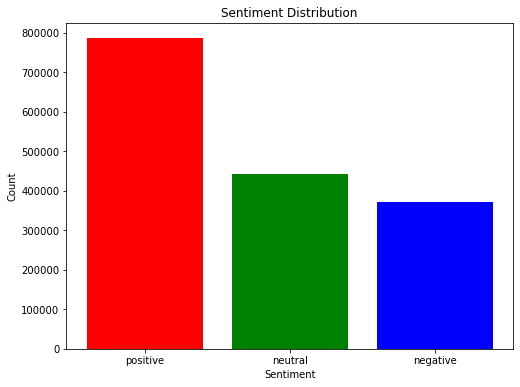

In [26]:

sentiment_counts = final_df.groupBy("sentiment").count()

# Convert PySpark DataFrame to Pandas DataFrame for plotting
sentiment_counts_pd = sentiment_counts.toPandas()

# Create a bar chart to visualize sentiment distribution
plt.figure(figsize=(8, 6))

plt.bar(sentiment_counts_pd["sentiment"], sentiment_counts_pd["count"], color=['red', 'green', 'blue'])

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the plot
plt.show()


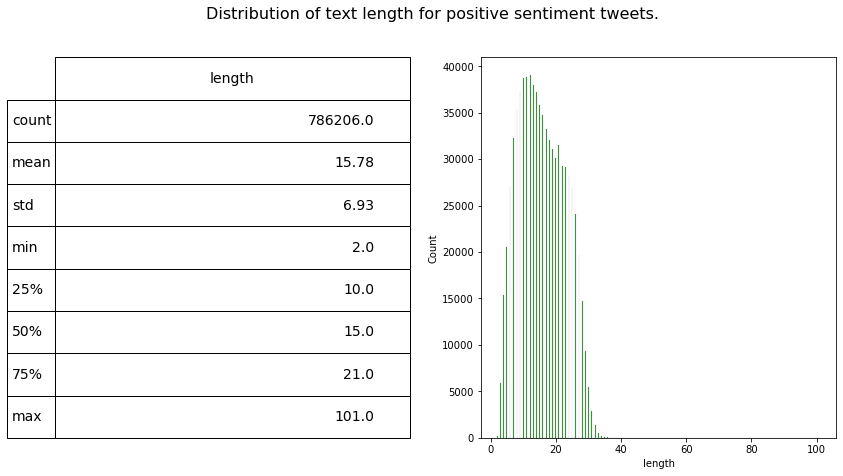

In [38]:
from pyspark.sql.functions import col, size,split

final_df = final_df.withColumn('length', size(split(col('text'), ' ')))

# Convert PySpark DataFrame to Pandas DataFrame for plotting 
final_df_pd = final_df.toPandas()

# Plot the histogram
fig = plt.figure(figsize=(14, 7))

ax1 = fig.add_subplot(122)
sns.histplot(final_df_pd[final_df_pd['sentiment'] == 'positive']['length'], ax=ax1, color='green')

describe = final_df_pd['length'][final_df_pd['sentiment'] == 'positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')

font_size = 14
bbox = [0, 0, 1, 1]

table = ax2.table(cellText=describe.values, rowLabels=describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)

fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()


In [27]:
## sample df 
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number


# Add a row number column for each sentiment group
window_spec = Window.partitionBy("sentiment").orderBy("text_processed")
sentiment_word = sentiment_df.withColumn("row_number", row_number().over(window_spec))

# Get the 200 number of rows for any sentiment group
min_rows = 200 

# Sample 200 rows for each sentiment group
sampled_df = sentiment_word.filter(col("row_number") <= min_rows).drop("row_number")

# Show the sampled DataFrame
sampled_df.show(truncate=False)

+----------+--------+---------------+----------------------------------------------------------------------------------------------------------------------------------+-------------------+--------------------------------------------------------------------------------------------------+-------------------+---------------------+---------+
|id        |flag    |user           |text                                                                                                                              |formatted_date     |text_processed                                                                                    |sentiment_score    |sentiment_vader_score|sentiment|
+----------+--------+---------------+----------------------------------------------------------------------------------------------------------------------------------+-------------------+--------------------------------------------------------------------------------------------------+-------------------+-------------

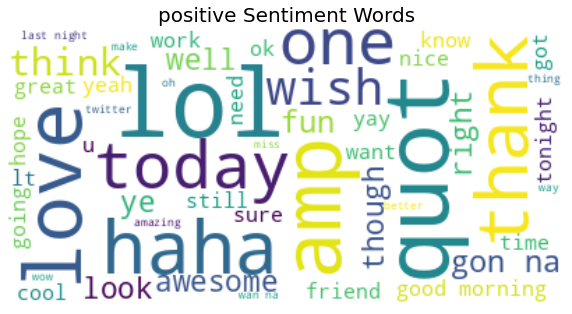

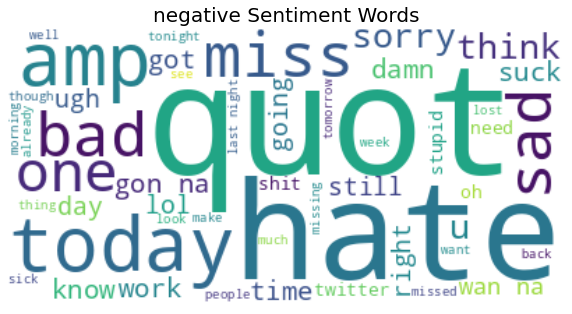

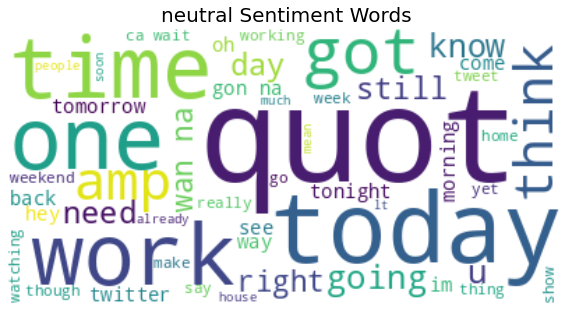

In [29]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt

sampled_df=sentiment_df[['text_processed','sentiment']]
sampled_df_pd = sampled_df.toPandas()

def wordcount_gen(df, sentiment):
    '''
    Generating Word Cloud
    inputs:
       - df: tweets dataset (Pandas DataFrame)
       - sentiment: Positive/Negative/Neutral
    '''
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.sentiment == sentiment]['text_processed']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50,
                   stopwords=STOPWORDS )

    # Generate and plot wordcloud
    wordcloud = wc.generate(combined_tweets)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('{} Sentiment Words'.format(sentiment), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(sampled_df_pd, 'positive')

# Negative tweet words
wordcount_gen(sampled_df_pd, 'negative')

# Neutral tweet words
wordcount_gen(sampled_df_pd, 'neutral')


In [36]:
sentiment_data=final_df.toPandas()
sentiment_data.to_csv("sentiment_data.csv")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

In [31]:
final_df.show(2)

+----------+--------+---------------+--------------------+-------------------+---------+
|        id|    flag|           user|                text|     formatted_date|sentiment|
+----------+--------+---------------+--------------------+-------------------+---------+
|1467810369|NO_QUERY|_TheSpecialOne_|@switchfoot http:...|2009 04 06 22:19:45| negative|
|1467810672|NO_QUERY|  scotthamilton|is upset that he ...|2009 04 06 22:19:49| negative|
+----------+--------+---------------+--------------------+-------------------+---------+
only showing top 2 rows



### Insert last df into mongo

In [34]:
##mongodb connection
import pymongo
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["twitter"]
collection = db["final"]

In [35]:
df_last=final_df.toPandas()

records = df_last.to_dict(orient='records')
collection.insert_many(records)


ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 655129300f4395cb3c6a7202, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>

In [ ]:
record_count = collection.count_documents({})
record_count

### LSTM Prediction 

In [45]:
import re
data=final_df.toPandas()
data = data[data.sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'positive'].size)
print(data[ data['sentiment'] == 'negative'].size)

for idx,row in data.iterrows():
    row[5] = row[5].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy

4717236
2223048


In [46]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='Adam', loss='binary_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 37, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spati  (None, 37, 128)           0         
 alDropout1D)                                                    
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
Total params: 511194 (1.95 MB)
Trainable params: 511194 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [47]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(774998, 37) (774998, 2)
(381716, 37) (381716, 2)


In [48]:
data["sentiment"].unique()

array(['negative', 'positive'], dtype=object)

In [ ]:
 batch_size = 512
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=5,
                    validation_data=(X_test, Y_test),)

Epoch 1/5


2023-11-12 22:34:54.416140: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 114699704 exceeds 10% of free system memory.


 981/1514 [==================>...........] - ETA: 3:59 - loss: 0.1695 - accuracy: 0.9333